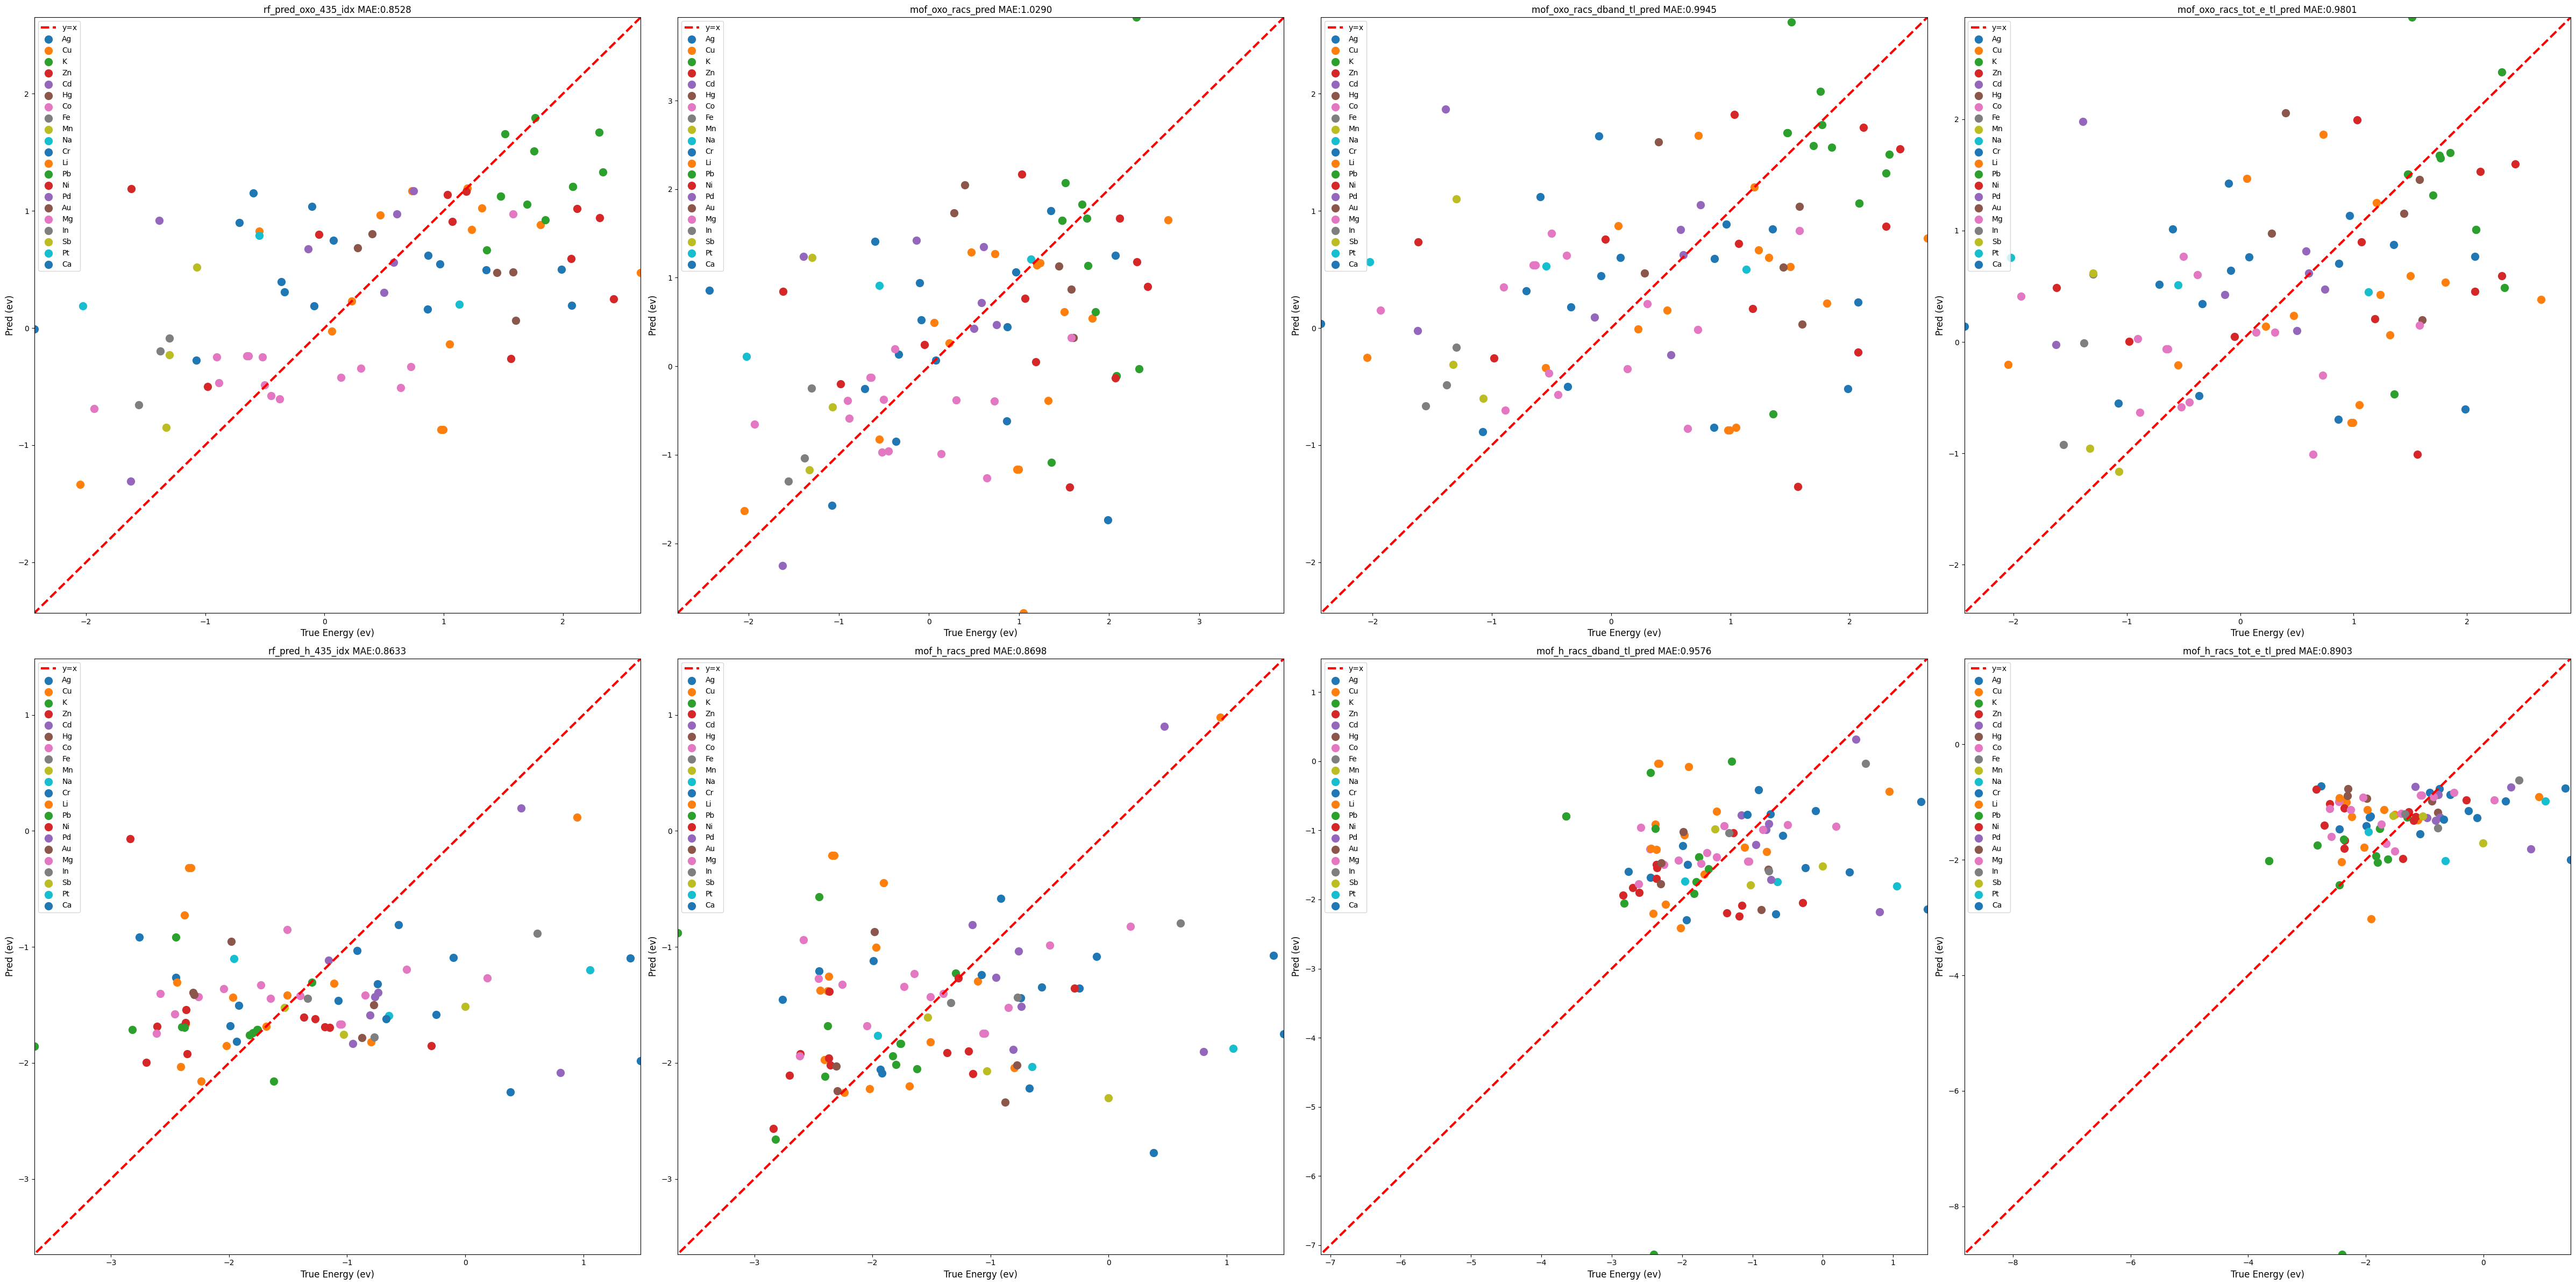

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_absolute_error
import colorlover as cl

# Create a figure with 4x4 subplots
props = ['oxo','h']
# columns = ["rf", "align-raw", "nn", "align-tl"]

n_rows = 1



src_file_path = "./labels/qmofruns_2_suffled.csv"
df_source = pd.read_csv(src_file_path, index_col = 0)
df_source['ids'] = df_source['MOF'] +'.cif_'+ df_source['Site'].astype(str)
df_source = df_source.drop_duplicates(subset = 'ids')

n = 4

# Example data for each subplot
fig, axes = plt.subplots(len(props), n, figsize=(12 * n, 12 * len(props)))
for k, prop in enumerate(props):
    rf_racs = f"./output/rf_pred_{prop}_435_idx.csv"
    nn_racs_only = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_pred.csv"
    nn_racs_dband = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_dband_tl_pred.csv"
    nn_racs_tot_e = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_tot_e_tl_pred.csv"

    file_paths = [rf_racs, nn_racs_only, nn_racs_dband, nn_racs_tot_e]
    for i, file_path in enumerate(file_paths):
        df = pd.read_csv(file_path, index_col = 0)

        df = df.merge(df_source, how='inner', left_on='ids_test', right_on = 'ids')

        preds = df["predictions"].values
        preds = np.clip(preds, None, 4)
        df['predictions'] = preds
        labels = df["labels"].values
        mae = np.mean(np.absolute(preds - labels))
        
        axes[k][i].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
        metals = df['Metal'].unique()
        axes[k][i].set_xlim(min(min(labels), min(preds)), max(max(labels), max(preds)))
        axes[k][i].set_ylim(min(min(labels), min(preds)), max(max(labels), max(preds)))
        axes[k][i].set_xlabel('True Energy (ev)', fontsize=12)
        axes[k][i].set_ylabel('Pred (ev)', fontsize=12)
        axes[k][i].set_title(f"{file_path.split('/')[-1].rstrip('.csv')} MAE:{mae:.4f}", fontsize=12)
        colormap = cl.to_numeric(cl.scales['12']['qual']['Set3'])
        # colors = [cl.to_numeric(c) for c in colormap]
        for j, metal in enumerate(metals):
            labels = df[df["Metal"] == metal]['labels'].values
            preds = df[df["Metal"] == metal]['predictions'].values
            axes[k][i].scatter(labels, preds, s=100, marker='o', label = metal)


        axes[k][i].legend()
# for i in range(n_rows):
#     for j in range(n_cols):
#         row = rows[i]
#         col = columns[j]
#         axes[i, j].set_title(f'{row}_{col}')
#         filename = "_".join([col.split("_")[0], row, col.split("_")[1], prop]) + '.csv'
#         df = pd.read_csv(os.path.join("pred", filename))
#         preds = df["predictions"].values
#         labels = df["labels"].values
#         axes[i, j].scatter(labels, preds)
#         axes[i, j].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
#         axes[i, j].set_xlim(min(labels), max(labels))
#         axes[i, j].set_ylim(min(labels), max(labels))

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

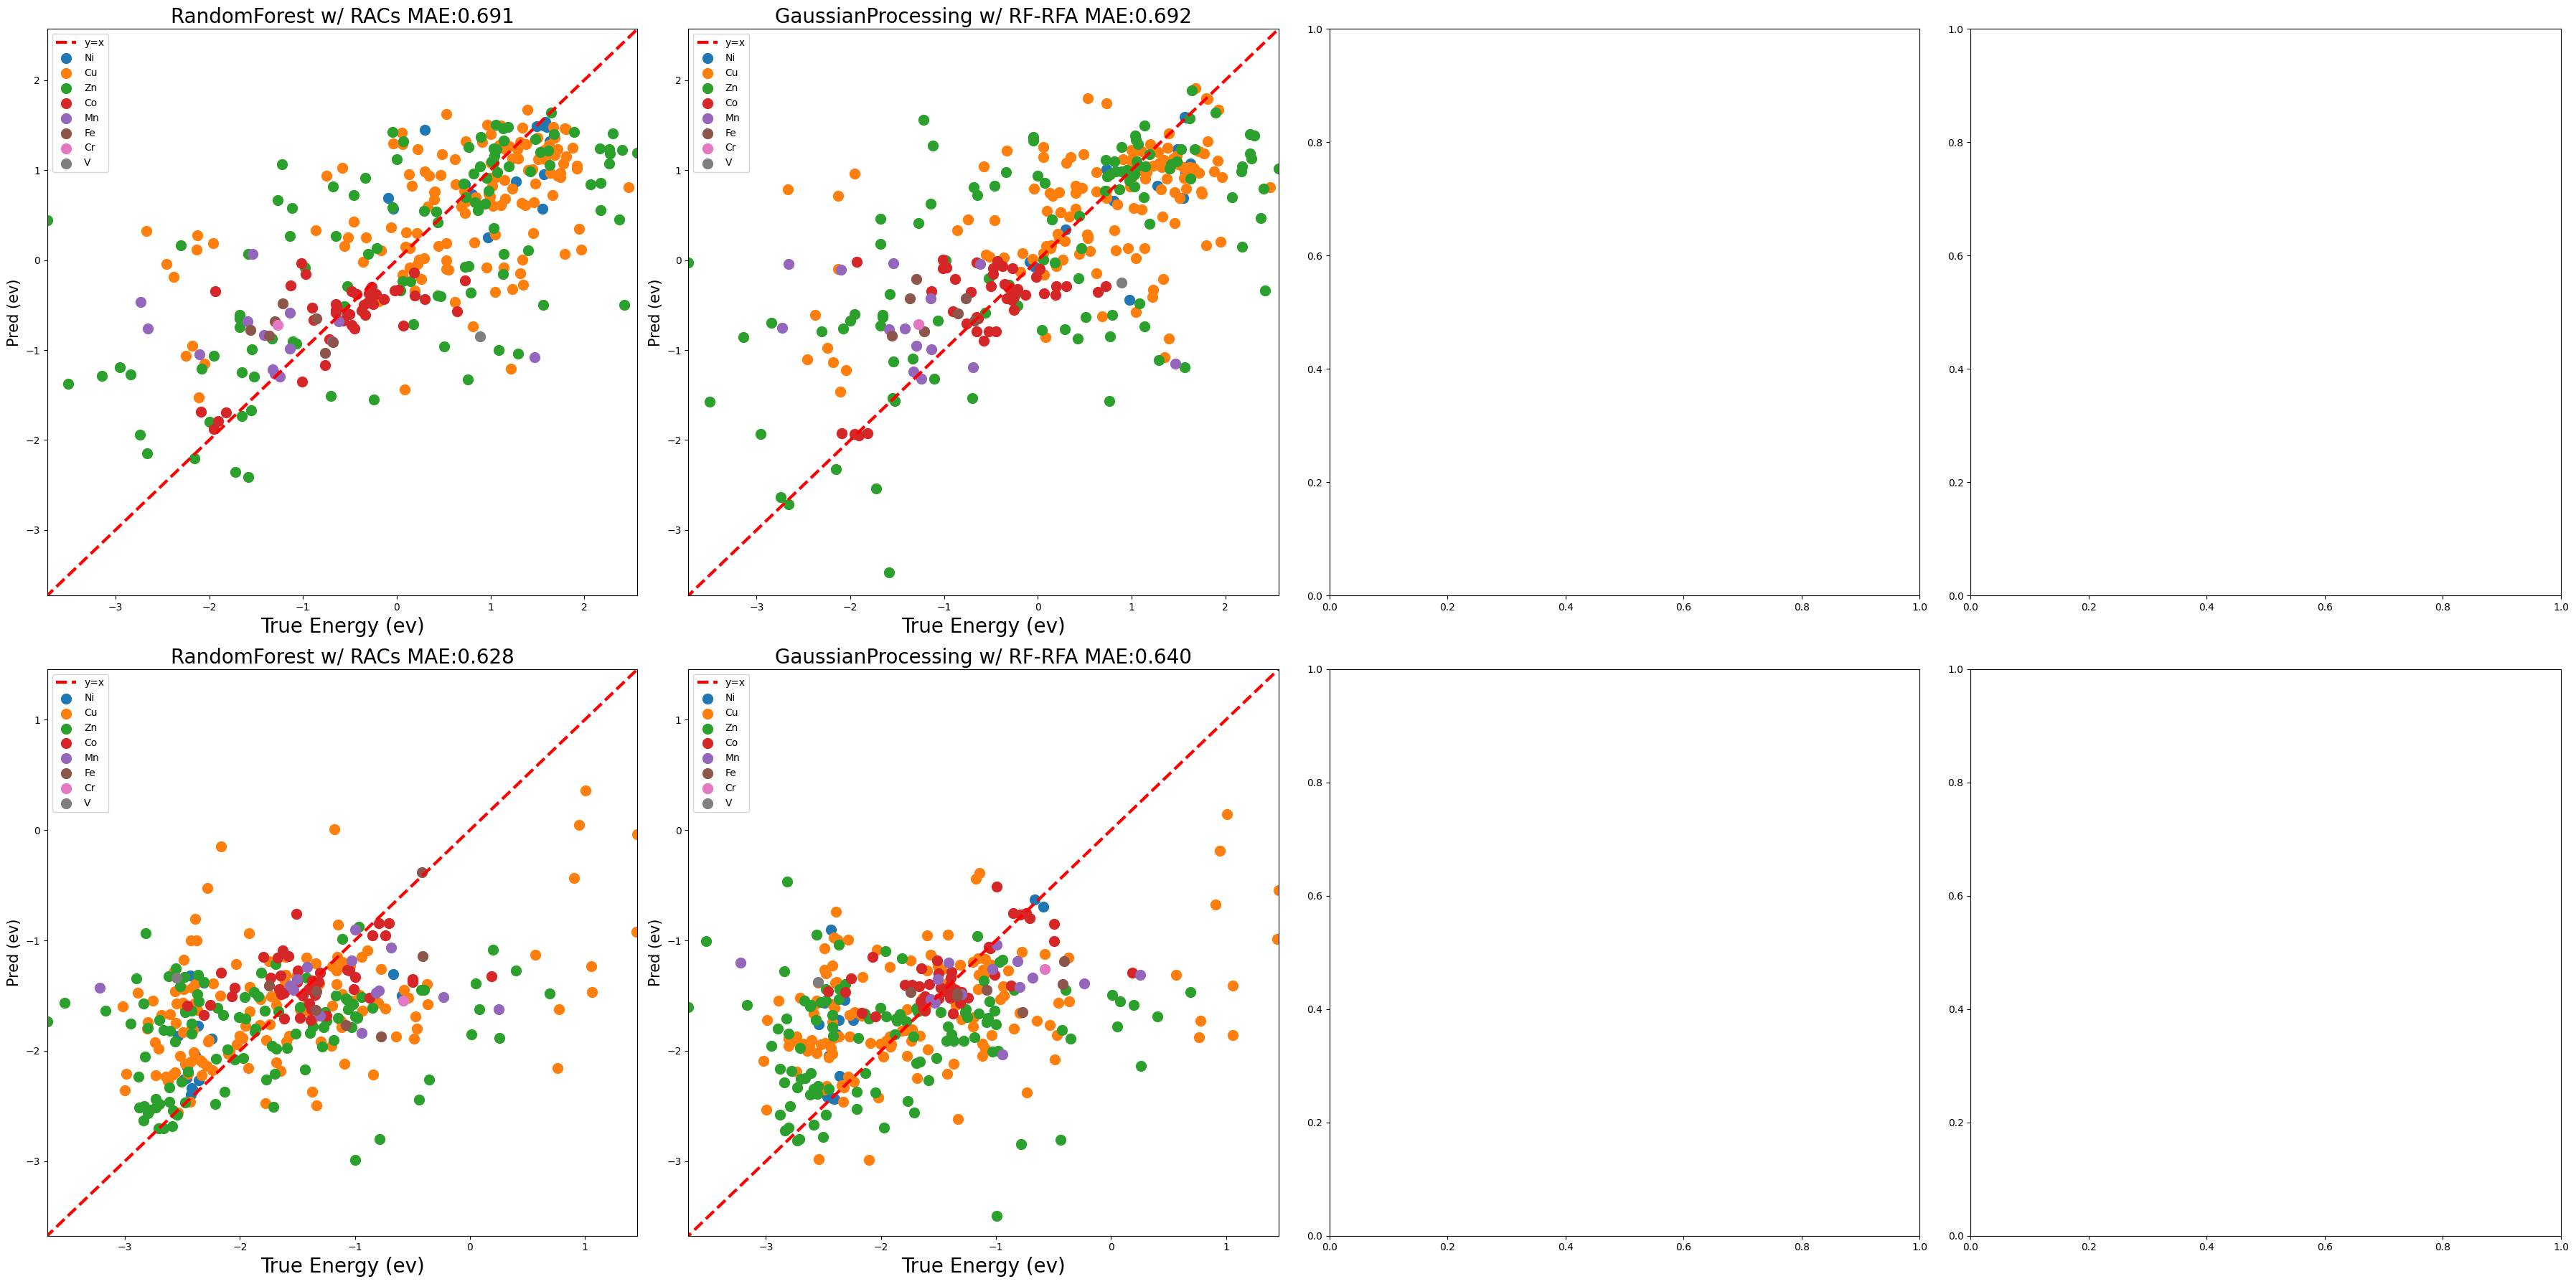

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_absolute_error
import colorlover as cl

# Create a figure with 4x4 subplots
props = ['oxo','h']
# columns = ["rf", "align-raw", "nn", "align-tl"]

n_rows = 1

n = 4

src_file_path = "/scratch/yll6162/MOF-oxo/labels/Combined_Energies_Removed_Infeasible_Out.csv"
df_source = pd.read_csv(src_file_path, index_col = 0)
# df_source = df_source[df_source["Metal"] == "Cu"]
df_source['ids'] = df_source['MOF'] +'.cif_'+ df_source['Site'].astype(str)
df_source = df_source.drop_duplicates(subset = 'ids')

# Example data for each subplot
fig, axes = plt.subplots(len(props), n, figsize=(9 * n, 9 * len(props)))
for k, prop in enumerate(props):
    rf_racs = f"/scratch/yll6162/MOF-oxo/output/rf_pred_{prop}_325_idx_cv.csv"
    gp_racs = f"/scratch/yll6162/MOF-oxo/output/gp_pred_{prop}_325_idx_cv.csv"
    # nn_racs_only = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_pred_cv.csv"
    # nn_racs_dband = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_dband_tl_pred_cv.csv"
    # nn_racs_form_e = f"/scratch/yll6162/CrossPropertyTL/pred/mof/query_1/mof_{prop}_form_e_pred_otf.csv"
    # nn_racs_bandgap = f"/scratch/yll6162/CrossPropertyTL/pred/mof/query_1/mof_{prop}_bandgap_pred_otf.csv"
    # nn_racs_form_e = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_form_e_pred_cv.csv"
    # col_title = ["RandomForest w/ RACs", "GaussianProcessing w/ RF-RFA", "Formation Energy w/ Alignn Embeddings + RACs", "Bandgap w/ Alignn Embeddings + RACs",]
    col_title = ["RandomForest w/ RACs", "GaussianProcessing w/ RF-RFA"]

    file_paths = [rf_racs, gp_racs]
    for i, file_path in enumerate(file_paths):
        df = pd.read_csv(file_path, index_col = 0)
        df = df.merge(df_source, how='inner', left_on='ids_test', right_on = 'ids')
        preds = df["predictions"].values
        preds = np.clip(preds, None, 4)
        df['predictions'] = preds
        labels = df["labels"].values
        mae = np.mean(np.absolute(preds - labels))
        
        axes[k][i].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
        metals = df['Metal'].unique()
        axes[k][i].set_xlim(min(labels), max(labels))
        axes[k][i].set_ylim(min(labels), max(labels))
        axes[k][i].set_xlabel('True Energy (ev)', fontsize=20)
        axes[k][i].set_ylabel('Pred (ev)', fontsize=15)
        # axes[k][i].set_title(f"{file_path.split('/')[-1].rstrip('.csv')} MAE:{mae:.4f}", fontsize=20)
        axes[k][i].set_title(f"{col_title[i]} MAE:{mae:.3f}", fontsize=20)
        # axes[k][i].set_xticks(fontsize=13) 
        # axes[k][i].set_yticks(fontsize=13) 
        colormap = cl.to_numeric(cl.scales['12']['qual']['Set3'])
        # colors = [cl.to_numeric(c) for c in colormap]
        for j, metal in enumerate(metals):
            labels = df[df["Metal"] == metal]['labels'].values
            preds = df[df["Metal"] == metal]['predictions'].values
            axes[k][i].scatter(labels, preds, s=100, marker='o', label = metal)
        axes[k][i].legend()
# for i in range(n_rows):
#     for j in range(n_cols):
#         row = rows[i]
#         col = columns[j]
#         axes[i, j].set_title(f'{row}_{col}')
#         filename = "_".join([col.split("_")[0], row, col.split("_")[1], prop]) + '.csv'
#         df = pd.read_csv(os.path.join("pred", filename))
#         preds = df["predictions"].values
#         labels = df["labels"].values
#         axes[i, j].scatter(labels, preds)
#         axes[i, j].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
#         axes[i, j].set_xlim(min(labels), max(labels))
#         axes[i, j].set_ylim(min(labels), max(labels))

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [33]:
df_var.shape

(8113, 26)

In [ ]:
#Plot selected top k predictions


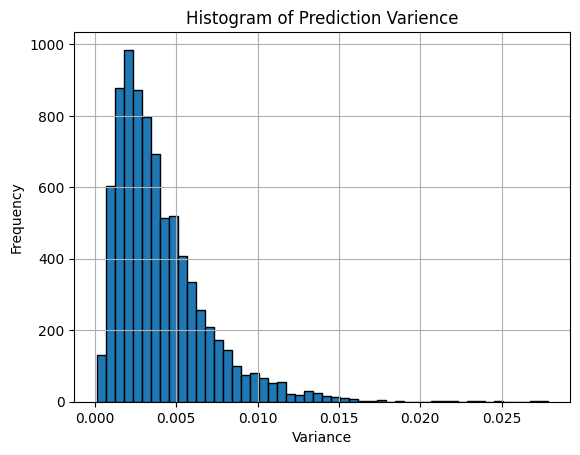

In [13]:
### Histogram of varience
# prop = "oxo"
# rf_file_path = f"/scratch/yll6162/MOF-oxo/output/rf_pred_{prop}_idx_iter_all_var.csv"
# df_var = pd.read_csv(rf_file_path, index_col = 0)
# plt.hist(df_var['row_variances'], bins=50, edgecolor='black')  # Adjust the number of bins as needed
# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.title('Histogram of Prediction Varience')
# plt.grid(True)
# plt.show()

In [6]:
list_fea = ['racs_bb-linker_connecting_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum', 'racs_bb-linker_functional_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-linker_functional_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum', 'Metal_Cd', 'Metal_Co', 'Metal_Ni']
len(list_fea)

12

In [7]:
fea_score = {'racs_bb-nodes_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum': 0, 'racs_bb-nodes_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.05351240634367671, 'Metal_Co': 0.002526248482740079, 'racs_bb-nodes_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.03416930943837071, 'Metal_Mn': 0.003058841494363973, 'racs_bb-nodes_prop-covalent_radius_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.017966569490135975, 'racs_bb-nodes_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.02073959395845193, 'racs_bb-nodes_prop-z_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.004213714249518219, 'racs_bb-nodes_prop-X_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.018807386674834614, 'racs_bb-nodes_prop-covalent_radius_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0005942176417915723, 'racs_bb-nodes_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.003404507754890318, 'racs_bb-nodes_prop-z_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.05188998320592697, 'racs_bb-nodes_prop-covalent_radius_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.03809128163967945, 'Metal_Fe': 0.0016801915837700854, 'racs_bb-linker_connecting_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.02622612478213604, 'racs_bb-nodes_prop-X_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.021018454788509056, 'racs_bb-linker_connecting_prop-covalent_radius_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.022043682279828447, 'racs_bb-nodes_prop-covalent_radius_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0029086172827490486, 'racs_bb-nodes_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum': 0.0019268078895892105, 'racs_bb-nodes_prop-X_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.03623900839823979, 'racs_bb-linker_connecting_prop-z_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.02711002961601716, 'racs_bb-linker_all_prop-z_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.03703191015474239, 'racs_bb-nodes_prop-z_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.035088840298716506, 'racs_bb-nodes_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.03363218618859998, 'racs_bb-linker_all_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.030417623443099062, 'racs_bb-nodes_prop-covalent_radius_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.0013445696257957662, 'racs_bb-linker_functional_prop-T_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.009972069694587304, 'racs_bb-linker_connecting_prop-covalent_radius_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.020189731951343215, 'racs_bb-nodes_prop-z_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.025148102938653327, 'racs_bb-nodes_prop-covalent_radius_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.019258682639770264, 'racs_bb-nodes_prop-T_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.02734222704947431, 'racs_bb-linker_functional_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.008601679322727152, 'racs_bb-linker_functional_prop-covalent_radius_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.02422159206070207, 'racs_bb-nodes_prop-T_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.012746395441869396, 'racs_bb-linker_connecting_prop-T_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.010501224518415286, 'racs_bb-linker_all_prop-covalent_radius_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.02404523546764925, 'racs_bb-linker_all_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.018895468382607916, 'racs_bb-linker_functional_prop-z_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.00755500603820447, 'racs_bb-linker_all_prop-z_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.03894816907910581, 'racs_bb-linker_connecting_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.01973420251998448, 'racs_bb-linker_connecting_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.015040817749919722, 'racs_bb-linker_functional_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.02035920985648354, 'racs_bb-linker_functional_prop-covalent_radius_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.011428857507981727, 'racs_bb-linker_functional_prop-X_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.009372924175923725, 'racs_bb-linker_functional_prop-z_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.004531122643986585, 'racs_bb-nodes_prop-T_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.00544302374401906, 'racs_bb-linker_connecting_prop-T_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.026749179572479465, 'racs_bb-linker_all_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.02423418975501468, 'racs_bb-linker_functional_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.026078458727038845, 'racs_bb-linker_connecting_prop-z_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.016282060302712953, 'racs_bb-linker_all_prop-covalent_radius_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.024484249777428246, 'racs_bb-linker_all_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.021401781438748824, 'racs_bb-nodes_prop-T_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.004662495800361044, 'racs_bb-linker_functional_prop-covalent_radius_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.013768676407582392, 'racs_bb-linker_functional_prop-covalent_radius_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.009002248520097234, 'racs_bb-linker_functional_prop-T_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.002427272792860813, 'racs_bb-nodes_prop-T_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.01876944973351502, 'racs_bb-linker_connecting_prop-T_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.025255575829321253, 'racs_bb-nodes_prop-covalent_radius_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.023325620338715325, 'racs_bb-linker_all_prop-covalent_radius_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.039509815407144266, 'racs_bb-linker_connecting_prop-X_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.02430267674247233, 'racs_bb-linker_connecting_prop-z_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.027071783235621094, 'racs_bb-linker_all_prop-T_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.02290161169687477, 'racs_bb-linker_connecting_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.025296292303765733, 'racs_bb-linker_functional_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.010479996794058533, 'racs_bb-linker_functional_prop-covalent_radius_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.010792256540875567, 'racs_bb-nodes_prop-T_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.008292237368272226, 'racs_bb-linker_functional_prop-z_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.0213492911376717, 'racs_bb-linker_all_prop-T_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.010763991329547418, 'racs_bb-linker_all_prop-X_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.032475443361152934, 'racs_bb-linker_all_prop-T_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.01433414205745831, 'racs_bb-linker_all_prop-z_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.025543639152211917, 'racs_bb-linker_functional_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.0038032472840104914, 'racs_bb-linker_all_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.034827375372114, 'racs_bb-linker_all_prop-z_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.01832327620433427, 'racs_bb-linker_functional_prop-z_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.0181841398145951, 'racs_bb-linker_connecting_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.02473574770568021, 'racs_bb-linker_all_prop-T_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.020870687793846487, 'racs_bb-linker_functional_prop-T_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.015523305167039703, 'racs_bb-linker_connecting_prop-T_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.028766753706221615, 'racs_bb-linker_all_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.05076663674202997, 'racs_bb-linker_connecting_prop-z_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.029545506149501466, 'racs_bb-linker_functional_prop-T_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.01058255380178652, 'racs_bb-linker_connecting_prop-covalent_radius_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.016440343667266433, 'racs_bb-linker_connecting_prop-T_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.02084482522230402, 'racs_bb-linker_functional_prop-T_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.01429651997509096, 'racs_bb-linker_functional_prop-X_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.031834948321173395, 'racs_bb-linker_connecting_prop-covalent_radius_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.01846870156655389, 'racs_bb-linker_all_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.026460345417888664, 'racs_bb-linker_connecting_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.00582157118089488, 'racs_bb-linker_all_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.039877539005529594, 'racs_bb-linker_all_prop-T_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.01575231989892567, 'racs_bb-linker_all_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.026244842357201814, 'racs_bb-linker_all_prop-covalent_radius_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.02297676075255639, 'racs_bb-linker_all_prop-covalent_radius_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.03160882414612276, 'racs_bb-linker_connecting_prop-covalent_radius_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.024232052630950962, 'racs_bb-linker_functional_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.01355405340950433, 'racs_bb-linker_connecting_prop-covalent_radius_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.024456974482266802, 'racs_bb-linker_connecting_prop-X_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.013593596415952258, 'racs_bb-linker_all_prop-I_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.031034943750495092, 'racs_bb-linker_functional_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.005390940772581176, 'racs_bb-linker_connecting_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.00994666806765565, 'racs_bb-linker_functional_prop-covalent_radius_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.009133768483985727, 'racs_bb-linker_functional_prop-T_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.017143025960005165, 'racs_bb-linker_connecting_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.009374554137624447, 'racs_bb-nodes_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.019597402206508963, 'racs_bb-linker_all_prop-T_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.028179384318875123, 'racs_bb-linker_all_prop-X_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.022753055005290346, 'racs_bb-linker_functional_prop-covalent_radius_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.013220343968441628, 'racs_bb-linker_functional_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.00905241660195566, 'racs_bb-linker_all_prop-covalent_radius_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.03614613436337322, 'racs_bb-linker_connecting_prop-covalent_radius_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.02778124092579215, 'racs_bb-linker_connecting_prop-X_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.021499664213163627, 'racs_bb-linker_functional_prop-X_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.011349441619601941, 'racs_bb-linker_all_prop-I_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.02869163653359985, 'racs_bb-linker_connecting_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.017941453918340566, 'racs_bb-linker_connecting_prop-T_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.023177949212693782, 'racs_bb-linker_all_prop-covalent_radius_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.03000271350056749, 'racs_bb-nodes_prop-I_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.007113728964794008, 'racs_bb-linker_connecting_prop-I_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.023950740944748028, 'racs_bb-linker_functional_prop-I_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.000682203471298326, 'racs_bb-linker_all_prop-X_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.0367791796329906, 'racs_bb-linker_functional_prop-I_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.024369765330327198, 'Metal_Cu': 4.564911954463291e-05, 'racs_bb-linker_functional_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.006216117786432607, 'racs_bb-linker_connecting_prop-I_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.017154914843583224, 'Metal_Ag': 0.0029815782469488905, 'racs_bb-nodes_prop-I_scope-1_propagg-product_corragg-sum_bbagg-sum': 0.0029469830237207617, 'Metal_Na': 0.00031870769404662713, 'Metal_K': 0.0025361009806643686, 'Metal_Li': 2.2848718115753286e-05, 'Metal_Pd': 0.0014440197042717706, 'Metal_Cd': 0.0017046531656186303, 'Metal_Sb': 0.0021508304946497026, 'Metal_Zn': 0.00035014543944678067, 'Metal_Ni': 0.001899750978009207, 'Metal_Cr': 0.0014810281031030215, 'Metal_Ga': 0.002713264274799676, 'Metal_Pt': 0.001379198013737315, 'Metal_Hg': 0.0029296009151937863, 'Metal_In': 0.0020812839217123624, 'Metal_Mo': 0.001320044384992114, 'Metal_Au': 0.0018021769075919902, 'Metal_Ca': 4.160870024272345e-05, 'Metal_Sn': 0.00019851744745991162, 'Metal_N': 0.000184916011947589, 'Metal_Mg': -0.00018820161988453155, 'Metal_Bi': 0.000648322443990712, 'Metal_V': 0.000216701013663112, 'Metal_Tl': 0.00126685388777259, 'Metal_Te': -0.0004451015808613068, 'Metal_As': -0.00010407494454800492, 'Metal_Pb': 0.0016303208930738, 'racs_bb-linker_all_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_O': 0.0002908464010606959, 'racs_bb-linker_connecting_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010604739, 'racs_bb-nodes_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_Rb': 0.0002908464010606959, 'Metal_Rh': 0.0002908464010606959, 'Metal_Ru': 0.0002908464010606959, 'Metal_Sm': 0.0002908464010606959, 'Metal_Sr': 0.0002908464010606959, 'Metal_Tb': 0.0002908464010606959, 'Metal_U': 0.0002908464010606959, 'Metal_Yb': 0.00029084640106091797, 'racs_bb-linker_all_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_functional_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_connecting_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_connecting_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum': 0.00029084640106091797, 'racs_bb-linker_functional_prop-T_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_connecting_prop-T_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.00029084640106091797, 'racs_bb-linker_all_prop-T_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_Al': 0.0002908464010606959, 'Metal_Ba': 0.0002908464010606959, 'Metal_C': 0.0002908464010606959, 'racs_bb-nodes_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.00029084640106091797, 'Metal_Cl': 0.0002908464010606959, 'racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_Cs': 0.0002908464010606959, 'racs_bb-linker_functional_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_Dy': 0.0002908464010606959, 'Metal_Er': 0.0002908464010606959, 'Metal_F': 0.0002908464010606959, 'racs_bb-linker_functional_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-nodes_prop-T_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_all_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959}

In [11]:
sorted_data = {k: v for k, v in sorted(fea_score.items(), key=lambda item: item[1], reverse=True)}

# Create a DataFrame from the sorted dictionary
df = pd.DataFrame(list(sorted_data.items()), columns=['Feature', 'MAE reduction'])

In [12]:
df.head(12)

,Feature,MAE reduction
0,racs_bb-nodes_prop-X_scope-1_propagg-diff_corr...,0.053512
1,racs_bb-nodes_prop-z_scope-0_propagg-product_c...,0.034169
2,racs_bb-linker_connecting_prop-X_scope-2_propa...,0.026226
3,racs_bb-nodes_prop-z_scope-1_propagg-diff_corr...,0.020740
4,racs_bb-nodes_prop-X_scope-0_propagg-product_c...,0.003405
5,Metal_Mn,0.003059
6,Metal_Ag,0.002982
7,racs_bb-nodes_prop-I_scope-1_propagg-product_c...,0.002947
8,Metal_Hg,0.002930
9,racs_bb-nodes_prop-covalent_radius_scope-0_pro...,0.002909


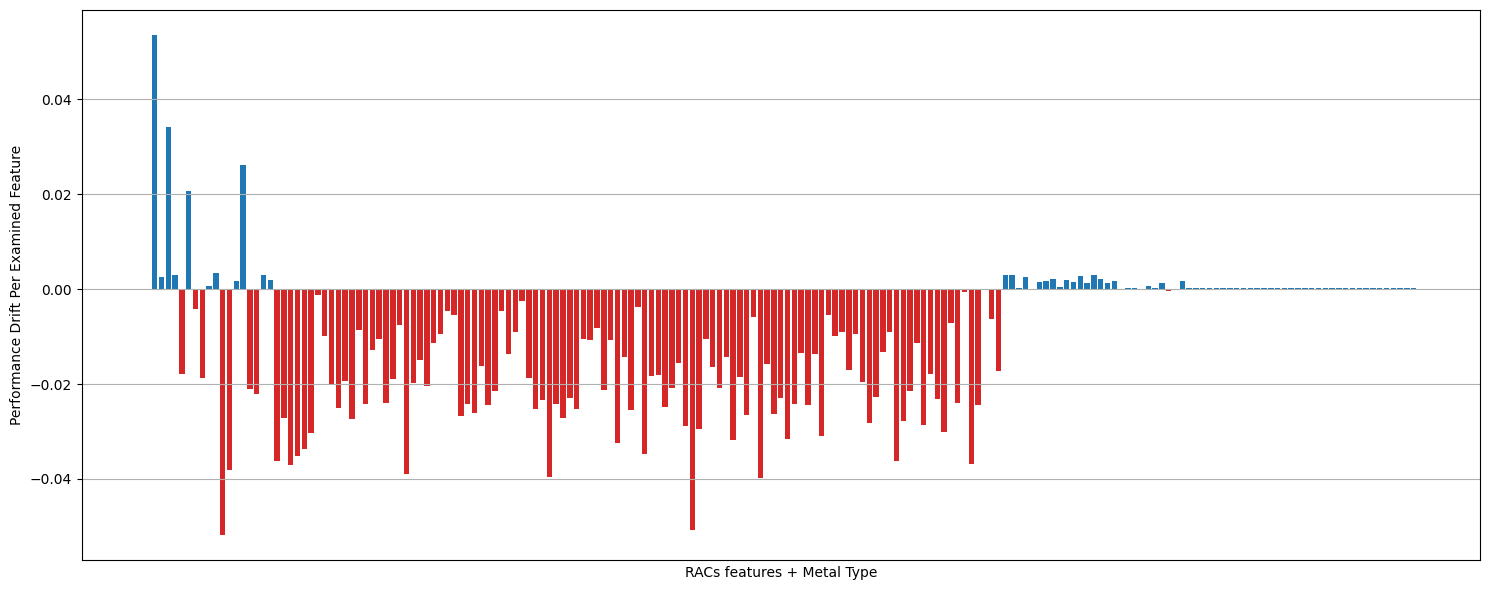

In [24]:
import matplotlib.pyplot as plt



# Extract keys and values for plotting
keys = fea_score.keys()
values = fea_score.values()
colors = ['tab:red' if value < 0 else 'tab:blue' for value in values]
plt.figure(figsize=(15, 6))
# Create a bar chart
plt.bar(keys, values, color = colors)

# Add labels and title (optional)
plt.xlabel('RACs features + Metal Type')
plt.ylabel('Performance Drift Per Examined Feature')

plt.xticks([])
plt.grid(True)
# Show the plot
plt.tight_layout()
plt.show()

{'racs_bb-nodes_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum': 0,
 'racs_bb-nodes_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.05351240634367671,
 'Metal_Co': 0.002526248482740079,
 'racs_bb-nodes_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.03416930943837071,
 'Metal_Mn': 0.003058841494363973,
 'racs_bb-nodes_prop-covalent_radius_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.017966569490135975,
 'racs_bb-nodes_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.02073959395845193,
 'racs_bb-nodes_prop-z_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.004213714249518219,
 'racs_bb-nodes_prop-X_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.018807386674834614,
 'racs_bb-nodes_prop-covalent_radius_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0005942176417915723,
 'racs_bb-nodes_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.003404507754890318,
 'racs_bb-nodes_prop-z_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.05188998320592697,
 'racs_bb-n